# M2 Innovation Technologique et Entrepreunariat
## Introduction au Machine Learning en situation

Auteurs: Guillaume Corlay, Marie Crappe & Livia Sossou

Date de la dernière modification du notebook : 9 janvier 2017

Modèle prédictif pour le challenge DataScience.net intitulé `ANAP-ATIH`

## 0. Set up

In [1]:
# The following command imports numpy as np and matplotlib as plt
%pylab inline
import pandas as pd
import multiprocessing
import re
import gc

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.cross_validation import KFold, cross_val_score
from itertools import combinations
#from joblib import Parallel, delayed  

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## 1. Chargement des données

In [2]:
train = pd.read_csv('../data/data2.csv', sep=';')
additional_data = pd.read_csv('../data/aggregated_hospidiag_data.csv', sep=';')
train.head(5)

,Finess,Raison sociale,Provenance des patients (département),Domaines d activités,"âge (deux classes >75 ans, <= 75 ans)",Nombre de séjours/séances MCO des patients en ALD,Nombre total de séjours/séances,annee,cible1
0,10007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D01-Digestif,<=75 ans,19,1061,2008,0.010624
1,10007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D01-Digestif,>75 ans,5,48,2008,0.053320
2,10007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D07-Cardio-vasculaire (hors cathétérismes vasc...,<=75 ans,0,1,2008,0.000000
3,10007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D16-Hématologie,<=75 ans,0,17,2008,0.000000
4,10007300,CLINIQUE AMBULATOIRE CENDANEG,01-Ain,D16-Hématologie,>75 ans,0,2,2008,0.000000


In [3]:
additional_data.drop('Unnamed: 0', axis=1, inplace=True)
additional_data.drop('Unnamed: 1', axis=1, inplace=True)
additional_data.drop('rs', axis=1, inplace=True)
additional_data.head()

,A10,A11,A12,A13,A14,A15,A7,A8,A9,CI_A1,...,RH9,annee,cat,champ_pmsi,finess,taa,taille_C,taille_M,taille_MCO,taille_O
0,-3.0,-3.0,-4,-4,-4,-4,-2,0,0,0.0,...,-3,2008,CLI,OQN,010007300,TAA,C1,M1,T1,-4
1,-3.0,-3.0,0,"67,2",-4,-4,-2,"5,03","12,58",158.0,...,-4,2008,CH,DGF,010007987,TAA,C0,M1,T1,-4
2,-3.0,-3.0,0,"87,7","79,4","56,2",-2,"0,76","3,97",4269.0,...,-4,2008,CH,DGF,010008407,TAA,C2,M2,T2,O2
3,-3.0,-3.0,"44,8","79,9","78,4","61,4",-2,"1,98","7,67",13685.0,...,-4,2008,CH,DGF,010780054,TAA,C3,M4,T3,O4
4,-3.0,-3.0,36,"71,8",74,"65,1",-2,"0,69","6,04",4233.0,...,-4,2008,CH,DGF,010780062,TAA,C2,M2,T2,O2


In [4]:
train.columns = ['finess', 'RS', 'Dept', 'Activite', 'Age', 'Nb_MCO', 'Nb_Sejours', 'annee', 'Target']
train.loc[train.Age == '<=75 ans', 'Age'] = 0
train.loc[train.Age == '>75 ans', 'Age'] = 1

In [5]:
# On sépare les cliniques 'privées' des CH et hôpitaux
prive = re.compile('CLINIQUE')
train['RS_prive'] = train.RS.apply(lambda x: len(re.findall(prive, x)))
train.drop('RS', axis=1, inplace=True)
train.head(5)

,finess,Dept,Activite,Age,Nb_MCO,Nb_Sejours,annee,Target,RS_prive
0,10007300,01-Ain,D01-Digestif,0,19,1061,2008,0.010624,1
1,10007300,01-Ain,D01-Digestif,1,5,48,2008,0.053320,1
2,10007300,01-Ain,D07-Cardio-vasculaire (hors cathétérismes vasc...,0,0,1,2008,0.000000,1
3,10007300,01-Ain,D16-Hématologie,0,0,17,2008,0.000000,1
4,10007300,01-Ain,D16-Hématologie,1,0,2,2008,0.000000,1


In [6]:
merged_data = train.merge(additional_data, on=['finess', 'annee'])

In [7]:
merged_data.head()

,finess,Dept,Activite,Age,Nb_MCO,Nb_Sejours,annee,Target,RS_prive,A10,...,RH6,RH8,RH9,cat,champ_pmsi,taa,taille_C,taille_M,taille_MCO,taille_O
0,280000449,78-Yvelines,D18-Maladies infectieuses (dont VIH),0,0,1,2008,0.000000,1,-3.0,...,-4,-3,-3,CLI,OQN,TAA,-4,M1,T1,-4
1,280000449,78-Yvelines,D19-Endocrinologie,0,0,3,2008,0.000000,1,-3.0,...,-4,-3,-3,CLI,OQN,TAA,-4,M1,T1,-4
2,280000449,78-Yvelines,D19-Endocrinologie,1,0,1,2008,0.000000,1,-3.0,...,-4,-3,-3,CLI,OQN,TAA,-4,M1,T1,-4
3,280000449,78-Yvelines,"D23-Toxicologie, Intoxications, Alcool",1,1,1,2008,0.124902,1,-3.0,...,-4,-3,-3,CLI,OQN,TAA,-4,M1,T1,-4
4,280000449,78-Yvelines,"D26-Activités inter spécialités, suivi thérape...",1,1,1,2008,0.124092,1,-3.0,...,-4,-3,-3,CLI,OQN,TAA,-4,M1,T1,-4


In [8]:
del train
del additional_data
gc.collect()
merged_data.drop('finess', axis=1, inplace=True)

MemoryError: 

In [10]:
le = preprocessing.LabelEncoder()
merged_data.Activite = le.fit_transform(merged_data.Activite)
merged_data.cat = le.fit_transform(merged_data.cat)
merged_data.champ_pmsi = le.fit_transform(merged_data.champ_pmsi)
merged_data.taa = le.fit_transform(merged_data.taa)
merged_data.taille_M = le.fit_transform(merged_data.taille_M)
merged_data.taille_MCO = le.fit_transform(merged_data.taille_M)

merged_data.Dept = le.fit_transform(merged_data.Dept)
merged_data.head()

,finess,Dept,Activite,Age,Nb_MCO,Nb_Sejours,annee,Target,RS_prive,A10,...,RH6,RH8,RH9,cat,champ_pmsi,taa,taille_C,taille_M,taille_MCO,taille_O
0,280000449,78,16,0,0,1,2008,0.000000,1,-3.0,...,-4,-3,-3,3,2,0,-4,2,2,-4
1,280000449,78,17,0,0,3,2008,0.000000,1,-3.0,...,-4,-3,-3,3,2,0,-4,2,2,-4
2,280000449,78,17,1,0,1,2008,0.000000,1,-3.0,...,-4,-3,-3,3,2,0,-4,2,2,-4
3,280000449,78,21,1,1,1,2008,0.124902,1,-3.0,...,-4,-3,-3,3,2,0,-4,2,2,-4
4,280000449,78,24,1,1,1,2008,0.124092,1,-3.0,...,-4,-3,-3,3,2,0,-4,2,2,-4


<h2> 2. Split des données </h2>

In [7]:
N_split = int(round(len(train)*0.80))

df_train = train.iloc[:N_split]
df_test = train.iloc[N_split:]

ytrain = df_train['Target']
ytest = df_test['Target']

df_train = df_train.drop('Target', axis=1)
df_test = df_test.drop('Target', axis=1)

## 3. Imputation des données manquantes

In [8]:
# Traitement des variables manquantes
imputer = preprocessing.Imputer()
xtrain = imputer.fit_transform(df_train)
xtest = imputer.transform(df_test)

## 4. Random Forest

In [10]:
rd = RandomForestRegressor(n_estimators=30, n_jobs=-1)
rd.fit(xtrain,ytrain)

MemoryError: 

In [ ]:
rd_preds = rd.predict(xtest)
print("rmse:      {}".format(sqrt(mean_squared_error(ytest, rd_preds))))

In [ ]:
# sort importances
plt.figure(figsize=(16,9))
features_names = train.drop('Target', axis=1).columns.values
indices = np.argsort(rd.feature_importances_)[::-1]
indices = indices[:10]
# plot as bar chart
plt.barh(np.arange(10), rd.feature_importances_[indices])
plt.yticks(np.arange(10) + 0.25, np.array(features_names)[indices])
_ = plt.xlabel('Relative importance')

without dummies & 100 trees => rmse: 0.061686654295611515 <br>
with dummies & 100 trees => rmse: 0.06043873775392981

## 6. Gradient Boosted Machines

In [16]:
gbm = GradientBoostingRegressor()
gbm.fit(xtrain,ytrain)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [31]:
gbm_preds = gbm.predict_proba(xtest)[:,1]
print("auc:      {}".format(roc_auc_score(ytest, gbm_preds)))
print("log_loss: {}".format(log_loss(ytest,gbm_preds)))

auc:      0.8655558103440149
log_loss: 0.17592976042222955


In [22]:
aucs = [ roc_auc_score(ytest, gbm_pred[:,1]) for gbm_pred in gbm.staged_predict_proba(xtest) ]

Puis pour le plot:

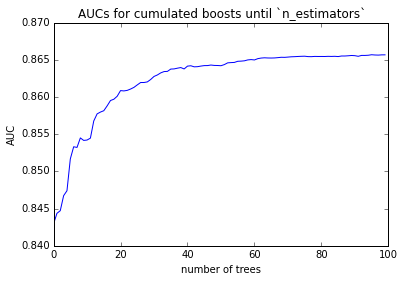

In [23]:
plt.plot(aucs)
plt.title("AUCs for cumulated boosts until `n_estimators`")
plt.xlabel("number of trees")
plt.ylabel("AUC")

On voit donc qu'en terme d'AUC, on fait du surapprentissage au delà d'une cinquantaine d'arbres